In [0]:
def download_news():
  '''
  a function to download a copy of 
  the news headline dataset
  '''
  !wget --no-check-certificate \
      https://www.researchgate.net/profile/Rishabh_Misra/publication/332141218_News_Category_Dataset/data/5ca2da43a6fdccab2f67c89b/News-Category-Dataset-v2.json \
      -O /tmp/news.json
  
  return None

download_news()

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

import string
import re

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as utils

In [0]:
news = pd.read_json('/tmp/news.json', lines=True)

In [0]:
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


##We are going to build a sequence model and train it on headlines of a given category of news and generate new headlines with it. First let's explore the data a bit.

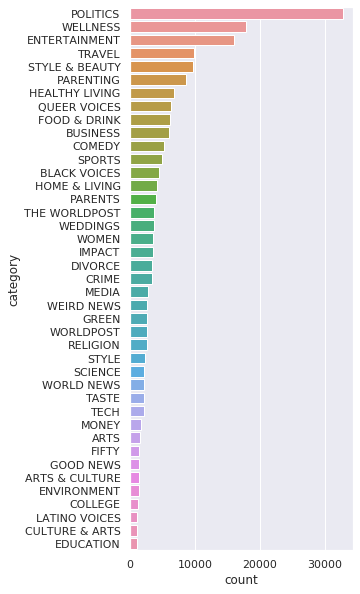

In [0]:
fig, ax  = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 10))
ax = sns.countplot(y="category", data = news, order = news['category'].value_counts().index)

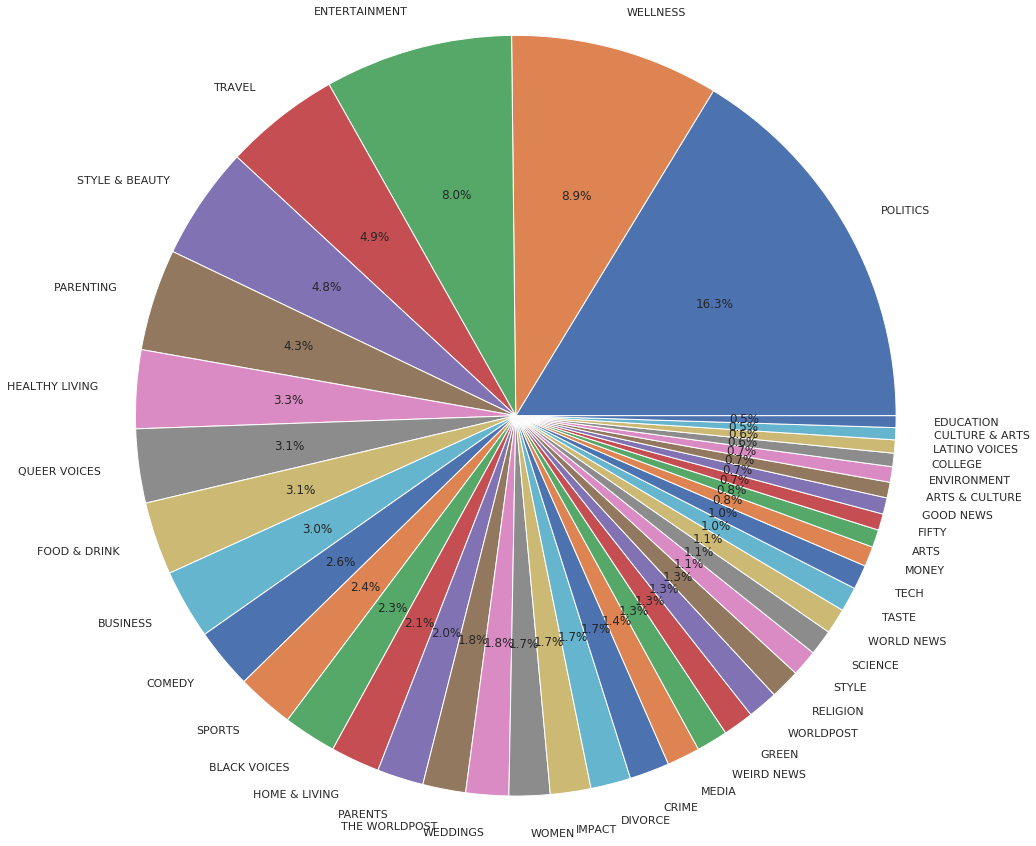

In [0]:
fig, ax = plt.subplots(figsize = (15,15))
sizes = news['category'].value_counts()
ax.pie(sizes.values, labels=sizes.index, autopct='%1.1f%%', shadow = False)
ax.axis('equal')
plt.show()

##A large portion of news fall into the three categories of politics, wellness and entertainment

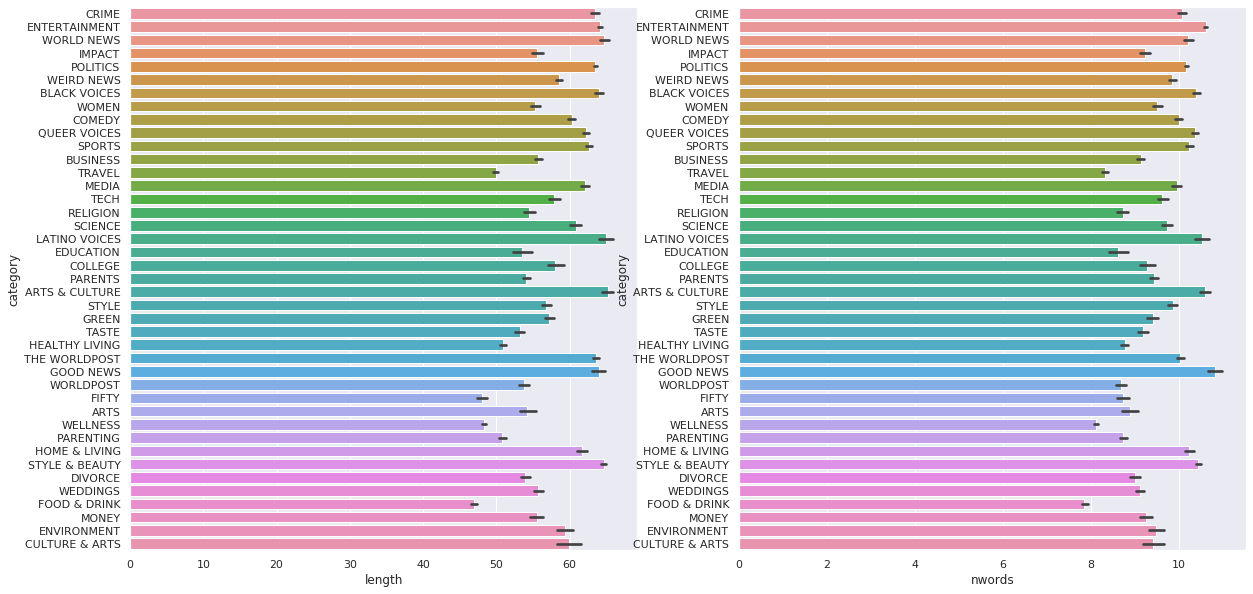

In [0]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

def char_length(text):    
    '''a function which returns the number of words in a text'''
    return len(text.split())    
 
news['length'] = news['headline'].apply(length)
news['nwords'] = news['headline'].apply(char_length)

fig, ax  = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
sns.barplot(y="category", x = "length", data = news, ax = ax[0])
sns.barplot(y="category", x = "nwords", data = news, ax = ax[1])

In terms of the character lengths and the number of words, there is no significant difference between the categories of different headlines.

From now on, let's focus on the category of Politics as it makes up roughly 16\% of the topics.

#Preprocessing

Let's look at the distribution of the character lengths of the headlines

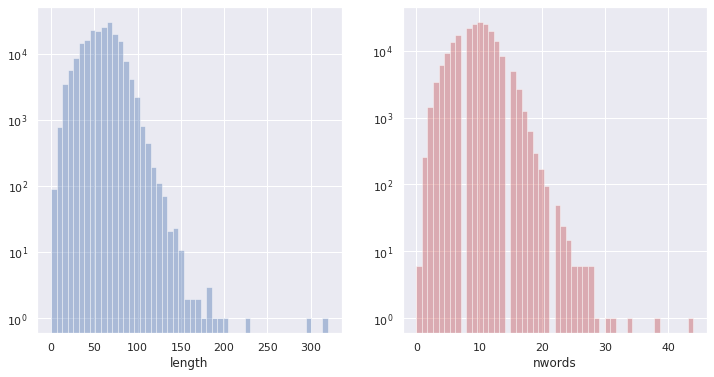

In [0]:
fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (12, 6))
sns.distplot(news.length, kde = False, ax = ax[0])
ax[0].set_yscale("log")
sns.distplot(news.nwords, kde = False, color = "C3", ax = ax[1])
ax[1].set_yscale("log")

The distribution of the number of words is highly skewed. Furthermore, there are a number of headlines with no words! We need to remove these instances from the data.

Additionally, for the purpose of text genration it is perhaps more convenient to work with text sequences that have more or less the same length. Thus we limit ourselves to the headlines with a number of words between 5 and 7.

In [0]:
news = news[(news.nwords > 5)&(news.nwords < 7)]

In [0]:
def char_lower(text):    
  '''a function which lowers the characters in a text'''
  return text.lower()

def expand(text):
  '''
  a function that expands some of the gramatical contractions
  '''
  text = re.sub(r"won\'t", "will not", text)
  text = re.sub(r"can\'t", "can not", text)
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ve", " have", text)
    
  return text

def remove_punctuations(text):
    '''
    a function that removes the punctuations of a given text
    '''
    table=str.maketrans('','',string.punctuation)
    
    return text.translate(table) 

In [0]:
#lower the characters
news["headline"] =  news['headline'].apply(char_lower)
#expand the grammatical contractions
news["headline"] =  news['headline'].apply(expand)   
#remove the punctuations
news["headline"] =  news['headline'].apply(remove_punctuations)

##Before feeding the text into a sequence interpretable by a model we need to tokenize it

In [0]:
def sequence_input_output(training): 
  '''
  a function that outputs a set of features (sequences) 
  for predicting labels (new sequences)
  '''
  tokenizer = Tokenizer()
  #fit the tokenizer on the headlines
  tokenizer.fit_on_texts(training.headline)
  #number of unique vocab
  num_vocab = len(tokenizer.word_index) + 1
  input_sequences = []
  for line in news.headline:
	  token_list = tokenizer.texts_to_sequences([line])[0]
	  for i in range(1, len(token_list)):
		  sequence_upto_i = token_list[:i+1]
		  input_sequences.append(sequence_upto_i)
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
  #split the input sequences into a set of features and labels
  features, labels = input_sequences[:,:-1],input_sequences[:,-1]
  #one-hot encoding of the labels
  labels = utils.to_categorical(labels, num_classes=num_vocab)

  return features, labels, num_vocab, max_sequence_len, tokenizer

In [0]:
features, labels, num_vocab, max_seq_len, tokenizer = sequence_input_output(news)

In [0]:
def create_model(learning_rate, dropout_rate, num_vocabs, max_seq_len):

  model = Sequential()
  model.add(Embedding(num_vocab, 10, input_length=max_seq_len-1))
  model.add(Bidirectional(LSTM(100, return_sequences = True)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(100))
  model.add(Dense(int(num_vocabs/4), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(num_vocabs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = learning_rate), metrics=['accuracy'])
  print(model.summary())

  return model

In [0]:
model = create_model(0.001, 0.2, num_vocab, max_seq_len)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 10)             145730    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 200)            88800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 3643)              367943    
_________________________________________________________________
dense_2 (Dense)              (None, 14573)             53104012  


In [0]:
history = model.fit(features, labels, epochs=400, verbose=1, batch_size=512)

Epoch 1/400
67774/67774 [==============================] - 30s 450us/step - loss: 7.4139 - acc: 0.0521
Epoch 2/400
67774/67774 [==============================] - 30s 447us/step - loss: 7.3360 - acc: 0.0551
Epoch 3/400
67774/67774 [==============================] - 30s 447us/step - loss: 7.2638 - acc: 0.0592
Epoch 4/400
67774/67774 [==============================] - 30s 441us/step - loss: 7.1797 - acc: 0.0627
Epoch 5/400
67774/67774 [==============================] - 30s 437us/step - loss: 7.0850 - acc: 0.0705
Epoch 6/400
67774/67774 [==============================] - 30s 442us/step - loss: 6.9816 - acc: 0.0808
Epoch 7/400
67774/67774 [==============================] - 30s 442us/step - loss: 6.8656 - acc: 0.0916
Epoch 8/400
67774/67774 [==============================] - 30s 440us/step - loss: 6.7396 - acc: 0.1013
Epoch 9/400
67774/67774 [==============================] - 30s 440us/step - loss: 6.6225 - acc: 0.1079
Epoch 10/400
67774/67774 [==============================] - 30s 439us/ste

In [0]:
def generate_new_example(start_word, nwords, tokenizers, max_seq_len):
  """
  a function for generating 
  new examples given a starting word 
  as well as the number of words in the 
  desired sequence
  """
  seed_text = start_words

  for word_count in range(nwords):

	  token_list = tokenizer.texts_to_sequences([seed_text])[0]
	  token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	  predicted = model.predict_classes(token_list, verbose=0)
	  output_word = ""
	  for word, index in tokenizer.word_index.items():
		  if index == predicted:
			  output_word = word
			  break
	  seed_text += " " + output_word
  
  print(seed_text)

  return None   